In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Classification

## MNIST

MNSIT is a dataset with small images of handwritten digits. This set is often called the "hello world" of Machine Learning

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()


/home/contente/anaconda3/envs/hands_on/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [4]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


There are 70 000 images and each image has 784 feature, because they have a dimension of 28 x 28 pixels and each one represents one pixel's intensity from 0 (white) to 255 (black).

Saving figure some_digit_plot


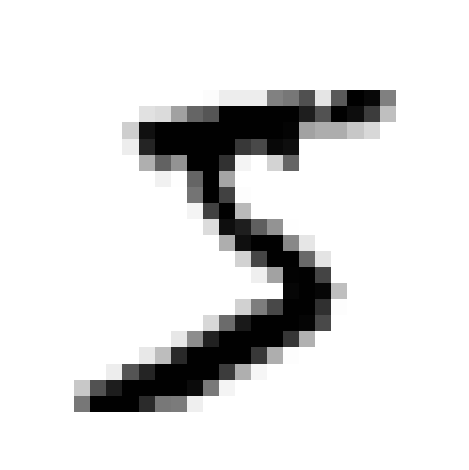

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()


In [6]:
y[0]


'5'

INdeed, the first data we have truly looks like a 5. But, it's a string so we have to cast "y" to an integer.

In [7]:
y.astype(np.uint8)


array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train = y_train.astype(np.int8)


Training a Binary Classfier

Let's simplify the problem for now and only try to identify one digit - for example, the number 5 can only distinguish between 5 or not-5, hance it's a binary classfier.

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
np.unique(y_train_5)


array([False,  True])

Let's use the Stochastic Gradient Descent (SGD) classfier. It has an advantage of being capable of handling very large datasets efficiently, one at a time.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])


array([ True])

# Performance Measures

## Implementing Cross-Validation

Remember that K-fold cross-validation means splitting the training set into K folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

We get over 90% accuracy! This demonstrates why accuracy is generally not the preferred performance measure for classifiers, specially when you are dealing with _skewed datasets_ (when some classes are much more frequent than others).

# Confusion Matrix

A much better way to evaluate a performance of a classfier is to look at the _confusion matrix_. The general idea is to count the number of times instances of class A are classified as class B.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets.

Just like the *cross_val_score()* function, the predict variant performs a K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you can get a clean prediction (meaning that the prediction is made by a model that never saw the data during trainig) for each instance in the training set.

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an *actual class* while each column represents a *predicted class*.

The first row consists in images of non-5s (the negative class):

- 53892 were **correctly** classified as non-5s: true negatives
- 687 were **wrongly** classified as 5s: false positives
  
The second row considers the images of 5s (the positie class):

- 1891 were **wrongly** classified as non-5s: false negatives
- 3530 were **correctly** classfied as 5s: true positives

Using the confusion matrix we can find the accuracy of the positive predictions, called _precision_:
$$
	\text{precison} = \frac{TP}{TP + FP}
$$

TP: True Positives
FP: False Positives

Precision is typically used along with another metric named *recall*, also called *sensitivity* or *true positive rate*: the ratio of positive instances that are correctly detected by the classifier:
$$
	\text{recall} = \frac{TP}{TP + FN}
$$

In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))

print(recall_score(y_train_5, y_train_pred))


0.8370879772350012
0.6511713705958311


If you need to compare two classfiers, you can combine both recall and precision into a single metric called F1 score. The F1 score is the harmonic mean of precision and recall.

High F1 score means both recall and precision are high.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = \frac{\text{TP}}{\frac{\text{FN + FP}}{2} + \text{TP}}
$$

Increasing precision reduces recall and vice versa, this is called the _precision/recall trade-off_

To understand this trade-off, imagine a SGDClassifier, it computes a score based on a *decision function*. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Lowering the threshold increases recall and reduces precision.

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


[2164.22030239]


array([False])

How to decide which threshold to use? Use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


Saving figure precision_recall_vs_threshold_plot


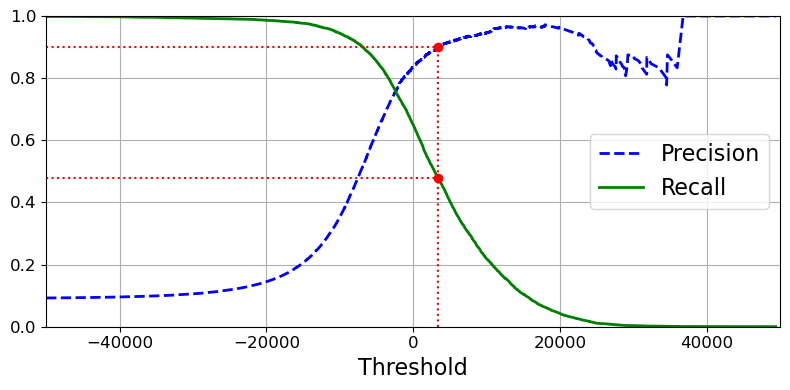

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()


Another way to select a good precision/recall trade-off is to plot precision directly against recall:

Saving figure precision_vs_recall_plot


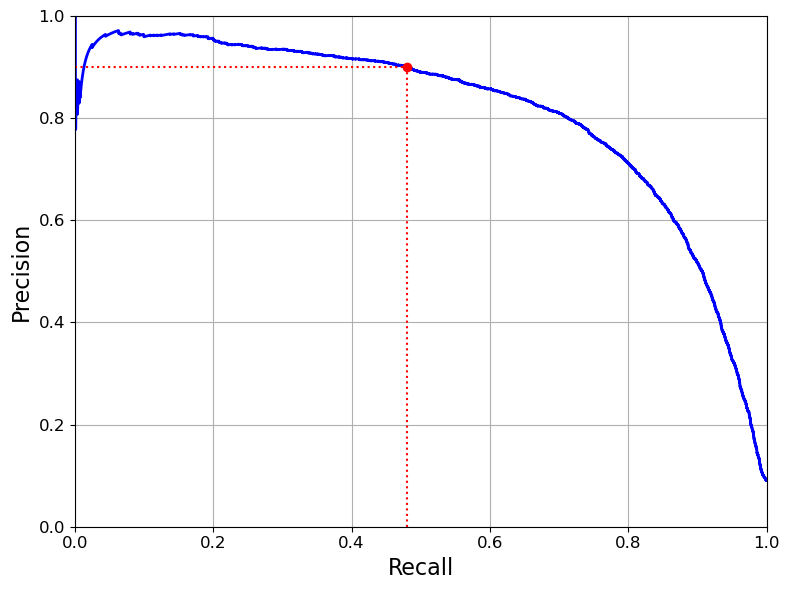

In [24]:
(y_train_pred == (y_scores > 0)).all()

def plot_precision_vs_recall(precisions, recalls):
	plt.plot(recalls, precisions, "b-", linewidth=2)
	plt.xlabel("Recall", fontsize=16)
	plt.ylabel("Precision", fontsize=16)
	plt.axis([0, 1, 0, 1])
	plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()


If we aim for a 90% precision, we should use a threshold of about 8000 by looking up the first plot.

A highp-precision classifier is not very useful if its recall is too low.

> If someone says, "Let's reach 99% precision," you should ask, "At what recall?".

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
recall_score(y_train_5, y_train_pred_90)


0.9000345901072293


0.4799852425751706

# The ROC Curve

The *receiver operating characteristic (ROC)* curve is another common tool used with binary classifiers. It plots the _true positive rate_ (another name for recall) against the _false positive rate_ (FPR). The FPR is the ratio of negative rate (TRN) which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence, the ROC curve plots *sensitivity* (recall) versus 1-*specificity*.

Saving figure roc_curve_plot


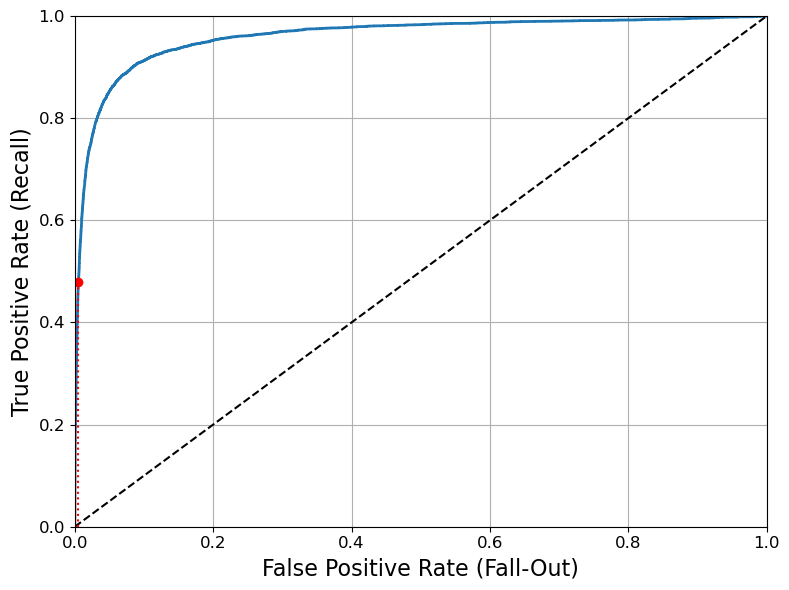

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()


The higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible.

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will ahve a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [28]:
# Computing the ROC AUC

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)


0.9604938554008616

When ROC and the PR curve are similar to each other, you may use this thumb rule:

You should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. If you look only at the ROC curve of the last example, you may think that the classifier is really good. But it's mostly due to few positives (5s) compared to the negatives (non-5s). On the other hand, the PR curce makes it clear that the classifier has room for improvement.

# Multiclass Classification

This type of classificatio can distinguish between more than two classes.

One way to create a system that can classify the digit images into 10 classes is to train 10 binary classifiers, one for each digit. Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the **one-versus-the-rest (OvR)** strategy (or **one-versus-all**)

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, 1s and 2s, etc. This is called **one-versus-one (OvO)** strategy. If there are N classes, you need to train N x (N - 1) / 2 classifiers. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for two classes that it must distinguish.